In [1]:
# 導入所需套件
import pandas as pd                 # 數據處理和分析
import numpy as np                  # 數值運算
import matplotlib.pyplot as plt     # 基礎繪圖
import seaborn as sns               # 進階繪圖，基於 matplotlib
from scipy import stats             # 用於統計檢定
import warnings                     # 用於處理警告訊息
from tabulate import tabulate

In [2]:
# 忽略警告訊息，讓 Notebook 輸出更簡潔
warnings.filterwarnings('ignore')

# 設定 Matplotlib 顯示中文 (如果你的系統需要)
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei'] # 替換為你的中文字體
plt.rcParams['axes.unicode_minus'] = False # 解決負號顯示問題

In [3]:
# 定義數據檔案路徑
data_path = '../data/train.csv' # data path

# 載入數據集
try:
    df = pd.read_csv(data_path)
    print("數據載入成功！")
    print(f"數據集包含 {df.shape[0]} 行和 {df.shape[1]} 列。")
except FileNotFoundError:
    print(f"錯誤：找不到數據檔案。請確認 '{data_path}' 路徑正確。")
    print("請將 'train.csv' 放到 projects/EDA_Titanic_Survival_Analysis/data/ 資料夾中。")

數據載入成功！
數據集包含 891 行和 12 列。


In [4]:
# 顯示前5行數據
print("數據集前5行：")
print(df.head())

# 顯示數據集的基本信息 (欄位、非空值數量、數據類型)
print("\n數據集基本信息：")
df.info()

# 顯示數據集的描述性統計 (針對數值型欄位)
print("\n數據集描述性統計：")
print(df.describe())

數據集前5行：
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN      

### 資料清洗與前處理

#### 缺失值處裡

In [5]:
print("--- 檢查缺失值 ---")
print(df.isnull().sum()) # 顯示每個欄位的缺失值數量
print("\n缺失值比例 (%):")
print((df.isnull().sum() / len(df) * 100).sort_values(ascending=False)) # 顯示缺失值比例，並按缺失數量降序排列

--- 檢查缺失值 ---
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

缺失值比例 (%):
Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Name            0.000000
Pclass          0.000000
Survived        0.000000
Sex             0.000000
Parch           0.000000
SibSp           0.000000
Fare            0.000000
Ticket          0.000000
dtype: float64


In [6]:
print("\n--- 處理 Cabin 欄位（缺失率過高，新增一布林值變數代表[有無客艙號資料]以取代該欄位） ---")

# --- 步驟 1: 檢查 Cabin 欄位是否存在，並基於它創建 Has_Cabin ---
if 'Cabin' in df.columns:
    # 創建一個新的特徵 'Has_Cabin'：1 = 有客艙號，0 = 沒有客艙號
    df['Has_Cabin'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
    print("已創建 'Has_Cabin' 欄位")
    # 在丟棄原始欄位之前，先展示原始 Cabin 和新創建的 Has_Cabin 的對比，確認轉換是否正確
    print("原始欄位[Cabin]與新欄位[Has_Cabin]對比（前5行）：")
    print(tabulate(df[['Cabin', 'Has_Cabin']].head(), headers='keys', tablefmt='pretty'))
    # 丟棄原始的 Cabin 欄位
    df = df.drop('Cabin', axis=1)
    print("已創建 'Has_Cabin' 欄位並丟棄原始 'Cabin' 欄位。")
else:
    # 如果 Cabin 欄位已經不存在，但 Has_Cabin 可能還沒創建（例如首次運行或清除輸出後）
    # 檢查 Has_Cabin 是否存在，如果不存在則報錯或提示
    if 'Has_Cabin' not in df.columns:
        # 這種情況通常表示你可能跳過了創建步驟或重啟了Kernel但沒有重新載入數據
        print("\033[31m!警告：'Cabin' 欄位已不存在，且 'Has_Cabin' 欄位尚未創建。請確保數據已正確載入或重新執行所有上一步驟。!\033[0m")
        
    else:
        print("\033[33m!注意：'Cabin' 欄位已不存在，且 'Has_Cabin' 欄位已存在，無需重複操作。!\033[0m")

# --- 步驟 2: 檢查新欄位 'Has_Cabin' 的狀態 ---
# 無論 Cabin 是否存在，Has_Cabin 應該在第一次執行時被創建或跳過。
# 這裡我們只檢查 Has_Cabin 的狀態，確保它能被訪問。
if 'Has_Cabin' in df.columns:
    print("\n新 'Has_Cabin' 欄位（前5行）：")
    print(tabulate(df[['Has_Cabin']].head(), headers='keys', tablefmt='pretty'))

    print("\n'Has_Cabin' 欄位值分佈：")
    print(df['Has_Cabin'].value_counts())
    print(f"有客艙號資料的乘客比例：{df['Has_Cabin'].value_counts(normalize=True)[1]:.2%}")
else:
    print("\n'Has_Cabin' 欄位不存在，請檢查上述步驟。")



--- 處理 Cabin 欄位（缺失率過高，新增一布林值變數代表[有無客艙號資料]以取代該欄位） ---
已創建 'Has_Cabin' 欄位
原始欄位[Cabin]與新欄位[Has_Cabin]對比（前5行）：
+---+-------+-----------+
|   | Cabin | Has_Cabin |
+---+-------+-----------+
| 0 |  nan  |     0     |
| 1 |  C85  |     1     |
| 2 |  nan  |     0     |
| 3 | C123  |     1     |
| 4 |  nan  |     0     |
+---+-------+-----------+
已創建 'Has_Cabin' 欄位並丟棄原始 'Cabin' 欄位。

新 'Has_Cabin' 欄位（前5行）：
+---+-----------+
|   | Has_Cabin |
+---+-----------+
| 0 |     0     |
| 1 |     1     |
| 2 |     0     |
| 3 |     1     |
| 4 |     0     |
+---+-----------+

'Has_Cabin' 欄位值分佈：
Has_Cabin
0    687
1    204
Name: count, dtype: int64
有客艙號資料的乘客比例：22.90%



--- 處理 Age 欄位 ---
在填充缺失值前，先視覺化 `Age` 在不同 `Pclass` 和 `Sex` 組中的分佈：


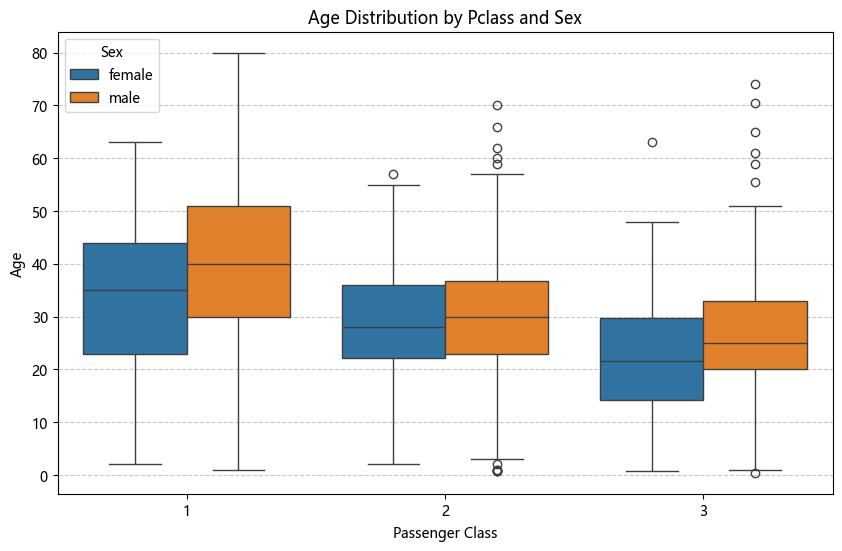

從上圖可見，不同艙位等級和性別的乘客，其年齡分佈確實存在差異。
例如，頭等艙（Pclass=1）的乘客普遍年齡較大，且男性與女性的年齡中位數也略有不同。
這支持我們採用分組中位數填充 `Age` 缺失值的策略。


In [39]:
print("\n--- 處理 Age 欄位 ---")
print("在填充缺失值前，先視覺化 `Age` 在不同 `Pclass` 和 `Sex` 組中的分佈：")

plt.figure(figsize=(10, 6))
sns.boxplot(x='Pclass', y='Age', hue='Sex', data=df)
plt.title('Age Distribution by Pclass and Sex')
plt.xlabel('Passenger Class')
plt.ylabel('Age')
plt.legend(title='Sex')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("從上圖可見，不同艙位等級和性別的乘客，其年齡分佈確實存在差異。")
print("例如，頭等艙（Pclass=1）的乘客普遍年齡較大，且男性與女性的年齡中位數也略有不同。")
print("這支持我們採用分組中位數填充 `Age` 缺失值的策略。")

In [ ]:
# 填充 Age 的缺失值：按 Pclass 和 Sex 分組，用中位數填充
# transform 會將填充後的值返回，並保持原始 DataFrame 的索引對齊
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

print("\n`Age` 欄位已按 `Pclass` 和 `Sex` 分組的中位數填充缺失值。")
print(f"再次檢查 `Age` 欄位的缺失值數量：{df['Age'].isnull().sum()}")


`Age` 欄位已按 `Pclass` 和 `Sex` 分組的中位數填充缺失值。
再次檢查 `Age` 欄位的缺失值數量：0


In [42]:
print("\n--- 處理 Embarked 欄位 ---")

# 1. 找出 Embarked 欄位的眾數 (最常見的值)
# .mode() 方法會返回一個 Series，因為可能有多個眾數。我們取第一個。
if 'Embarked' in df.columns:
    if df['Embarked'].isnull().sum() > 0: # 檢查是否確實有缺失值需要填充
        most_common_embarked = df['Embarked'].mode()[0]
        
        # 使用眾數填充缺失值
        df['Embarked'].fillna(most_common_embarked, inplace=True)
        
        print(f"`Embarked` 欄位已用眾數 '{most_common_embarked}' 填充缺失值。")
    else:
        print("`Embarked` 欄位沒有缺失值，無需填充。")
else:
    print("注意：`Embarked` 欄位不存在，請檢查數據集。")


# 2. 再次檢查 Embarked 欄位的缺失值數量，確保填充成功
print(f"再次檢查 `Embarked` 欄位的缺失值數量：{df['Embarked'].isnull().sum()}")

# 3. 檢查 Embarked 欄位的值分佈，確保填充後數據合理
print("\n`Embarked` 欄位值分佈：")
print(df['Embarked'].value_counts())


--- 處理 Embarked 欄位 ---
`Embarked` 欄位已用眾數 'S' 填充缺失值。
再次檢查 `Embarked` 欄位的缺失值數量：0

`Embarked` 欄位值分佈：
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


In [43]:
print("--- 檢查缺失值 ---")
print(df.isnull().sum()) # 顯示每個欄位的缺失值數量
print("\n缺失值比例 (%):")
print((df.isnull().sum() / len(df) * 100).sort_values(ascending=False)) # 顯示缺失值比例，並按缺失數量降序排列

--- 檢查缺失值 ---
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Has_Cabin      0
dtype: int64

缺失值比例 (%):
PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Embarked       0.0
Has_Cabin      0.0
dtype: float64
